In [241]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from xpbd_softbody_layer_batch import XPBDStepBatch
from xpbd_softbody_layer_batch import get_energy_boundary_batch

In [242]:
N_skin = 600
N_bandage = 200

In [243]:
# contact_sur_0 = torch.tensor([ 808,  809,  816,  825,  841,  842,  846,  848,  854,  858,  875,  880,
#           882,  885,  904,  916,  917,  919,  926,  927,  928,  929,  930,  931,
#           932,  933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
#           944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,
#           956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,
#           968,  969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
#           980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
#           992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
#          1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015,
#          1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027,
#          1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039,
#          1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,
#          1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063,
#          1064, 1065, 1066, 1067, 1068]) - 807
contact_sur_0 = torch.arange(200)
contact_sur_1 = torch.tensor([ 43,  50,  51,  54,  60,  61,  92, 103, 104, 106, 108, 110, 117, 154,
         158, 164, 165, 166, 168, 170, 176, 197, 198, 219, 220, 223, 228, 229,
         230, 235, 238, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
         429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
         443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
         457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
         471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
         485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
         499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
         513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,
         527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
         541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
         555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
         569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
         583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
         597, 598, 599])

In [244]:
control_point = 26

In [245]:
# load data
softbody = XPBDSoftbody()
# skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
skin_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
# bandage_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
bandage_mesh = softbody.add_thinshell(pv.Plane(center=(0, 0, 0.002), i_size=0.02, j_size=0.02), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([0, 1])
softbody.add_multi_boundary_constrain(1, 0, 0.0017, contact_sur_0, contact_sur_1)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, -0.001, 2)
softbody.fix_point(1, control_point)
# softbody.fix_less_than(1, 0.0022, 2)
# softbody.fix_larger_than(0, 0.0018, 2)
p_skin = skin_mesh.points.shape[0]

detect 2 object


In [246]:
softbody.V_list[1][26]

tensor([ 0.0094, -0.0091,  0.0020], dtype=torch.float64)

In [247]:
norm_vec = np.array([-1, 1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


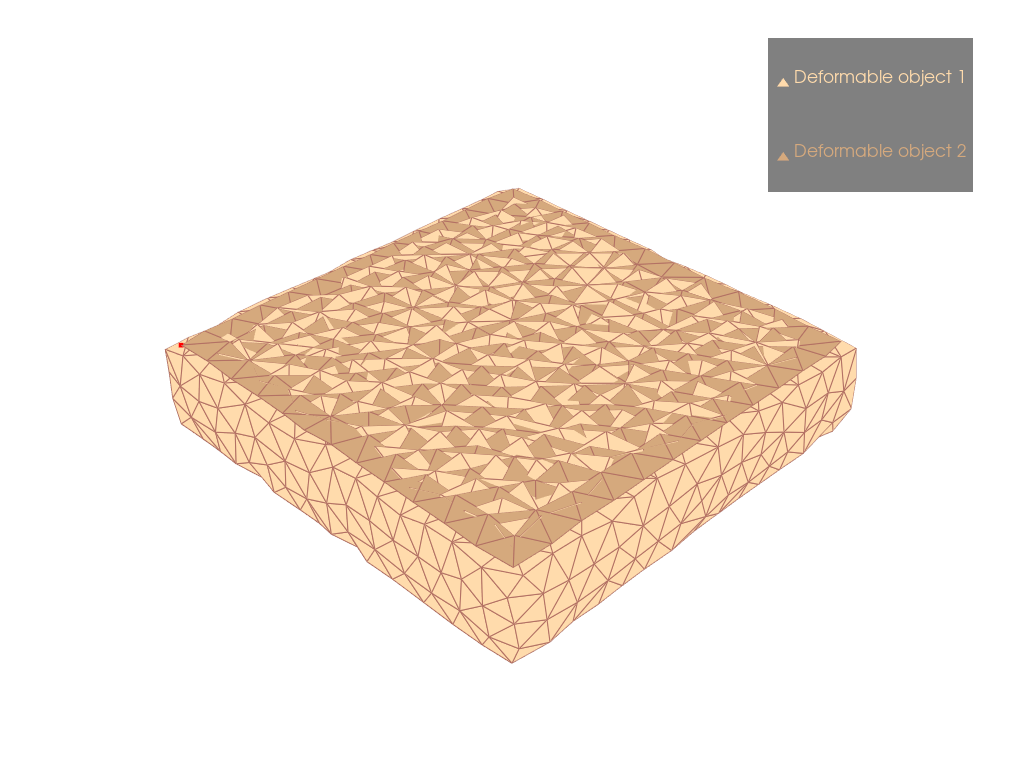

In [248]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + control_point].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [249]:
softbody.C_boundary_list[0].shape

torch.Size([895, 2])

In [250]:
# color = np.zeros(400)
# color[306] = 1

In [251]:
cloth_dist_stiffness = 1e3
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [252]:
stiffness_norm = -np.array([0, -1, 0])
stiffness_color = []
cnt = 0
for i in range(contact_sur_0.shape[0]):
    if (stiffness_norm @ softbody.V_list[1][contact_sur_0[i]].detach().cpu().numpy()) < 0:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
        stiffness_color.append(energy_max)
        cnt += 1
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

In [253]:
# contact_sur.shape[0]

In [254]:
# cnt

In [255]:
# center = torch.tensor([0, 0, 0])
# N_norm = torch.norm(softbody.V_list[1][contact_sur] - center, dim=1)
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max -  N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min())
#     stiffness_color.append(energy_max - N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min()))

In [256]:
# picked_stiffness = torch.from_numpy(np.array([228, 252, 253, 254, 205, 216, 215, 212, 211, 243, 213, 213, 213, 213, 261, 247, 257, 221, 222, 222, 222, 222, 227, 224, 232, 230]))
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     if contact_sur[i] in picked_stiffness:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
#         stiffness_color.append(energy_max)
#     else:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
#         stiffness_color.append(energy_min)

In [257]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


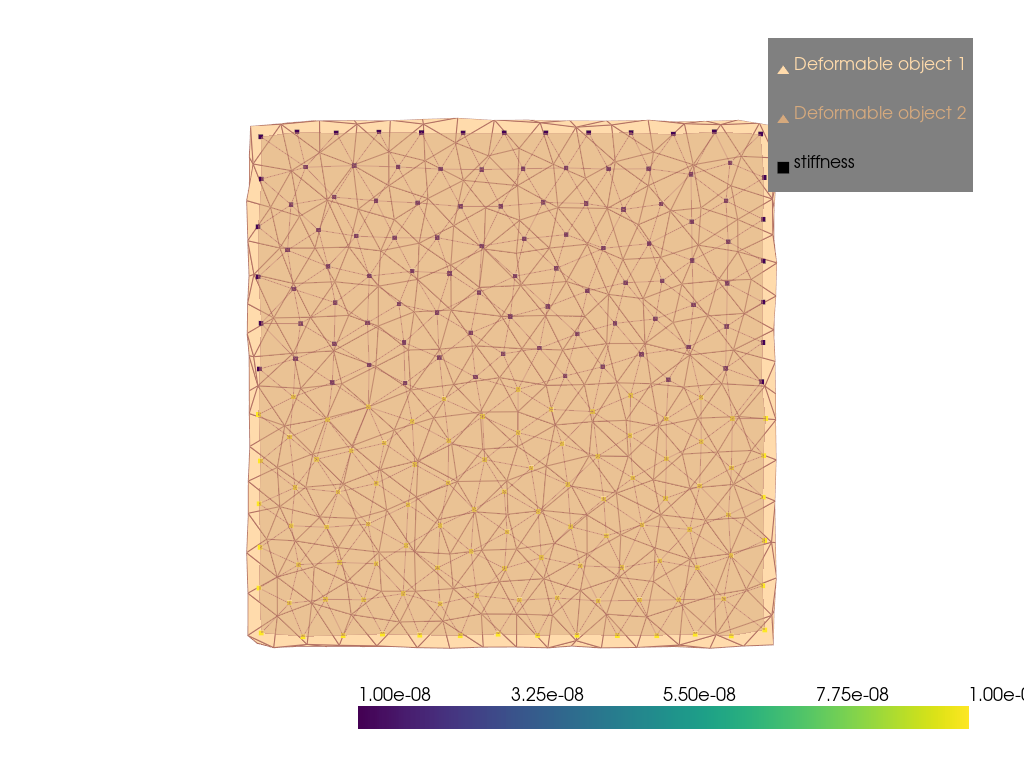

In [258]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur_0].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'xy'
pl.show()

In [259]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [260]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


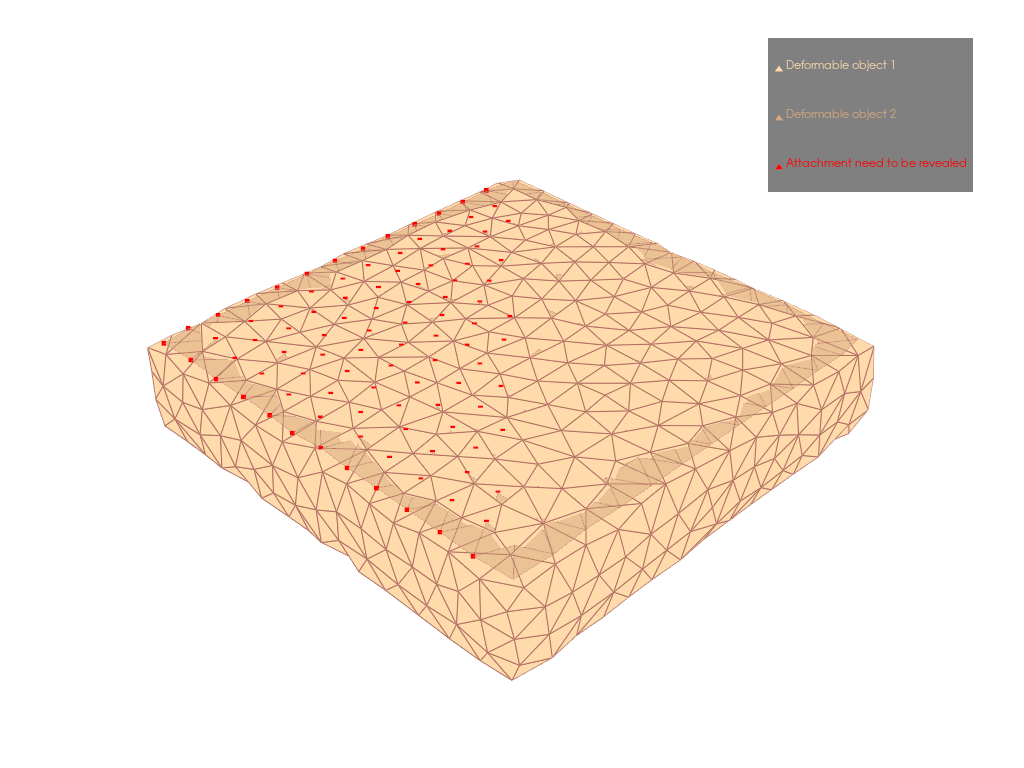

In [261]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [262]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 1e-8
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [263]:
def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
    return torch.norm(target - predict) / 100 + penalty * alpha + energy * 1e5

In [264]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    #predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    #target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    #unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc#, unreveal_acc

In [265]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([895, 2])

In [266]:
spline_list = []

In [267]:
# create direction control
start_point = np.array([[ 0.0094, -0.0091,  0.0020]])
start_point = torch.from_numpy(start_point).to(cfg.device)

spline_control = np.array([[ 0., 0.,  1.],
                           [ 0., 0.,  1.],
                           [ 0., 0.,  1.],
                           [ 0., 0.,  1.],
                           [ 0., 0.,  1.]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [268]:
sigma = 0.1
sample_points = 30
MPC_step = 5
opt_step = 1
step_size = 0.001

In [269]:
# init a trajectory for control
direction_vec = spline_control / (torch.transpose(torch.norm(spline_control, dim=1).reshape(1, 5), 0, 1) / step_size)
spline_trajectory = start_point.clone()
for i in range(spline_control.shape[0]):
    spline_trajectory = torch.vstack((spline_trajectory, spline_trajectory[-1] + direction_vec[i]))

In [270]:
spline_trajectory

tensor([[ 0.0094, -0.0091,  0.0020],
        [ 0.0094, -0.0091,  0.0030],
        [ 0.0094, -0.0091,  0.0040],
        [ 0.0094, -0.0091,  0.0050],
        [ 0.0094, -0.0091,  0.0060],
        [ 0.0094, -0.0091,  0.0070]], dtype=torch.float64)

In [271]:
for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=False,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))

100%|██████████| 6/6 [00:00<00:00, 12.00it/s]


In [272]:
TT_score_prev = eval(V_boundary_stiffness, boundary_mask)

In [273]:
spline_trajectory

tensor([[ 0.0094, -0.0091,  0.0020],
        [ 0.0094, -0.0091,  0.0030],
        [ 0.0094, -0.0091,  0.0040],
        [ 0.0094, -0.0091,  0.0050],
        [ 0.0094, -0.0091,  0.0060],
        [ 0.0094, -0.0091,  0.0070]], dtype=torch.float64)

In [274]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [275]:
B = sample_points
B_V_boundary_stiffness = V_boundary_stiffness.expand(B, *V_boundary_stiffness.shape)
B_V_dist_stiffness = V_dist_stiffness.expand(B, *V_dist_stiffness.shape)
B_V = softbody.V.expand(B, *softbody.V.shape).clone()
B_V_velocity = softbody.V_velocity.expand(B, *softbody.V_velocity.shape)
B_energy_coff = energy_coff.expand(B, *energy_coff.shape)
B_energy_threshold = energy_threshold.expand(B, *energy_threshold.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


tensor([ 0.0098, -0.0095,  0.0074], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


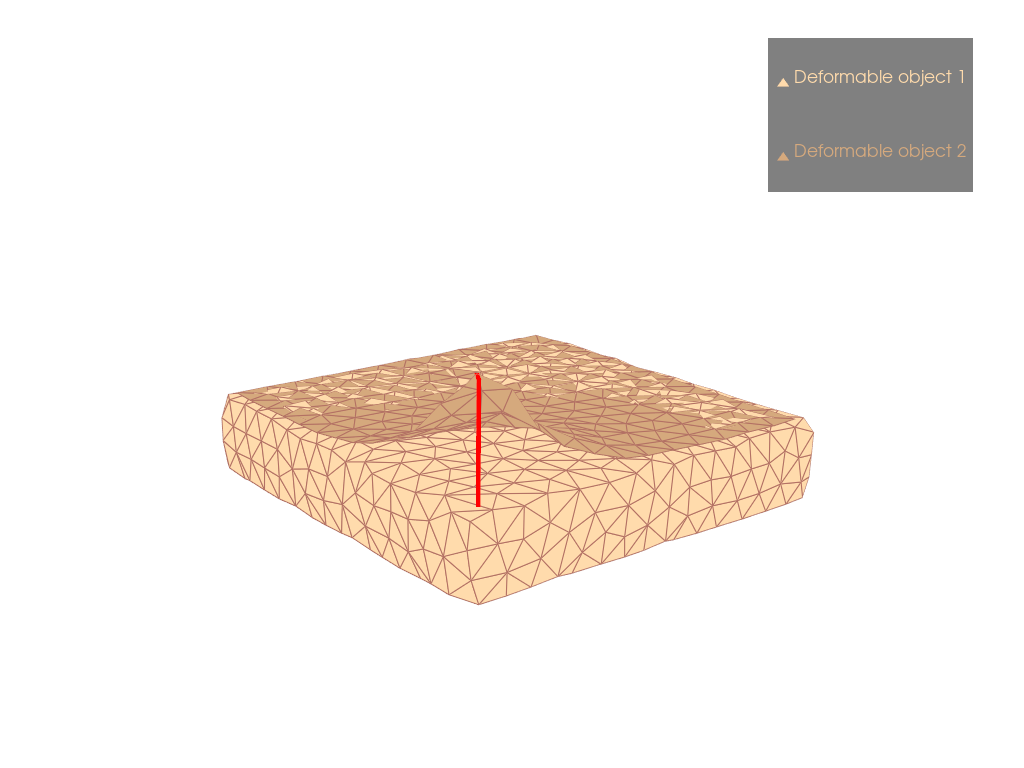

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


tensor([ 0.0103, -0.0100,  0.0079], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


tensor([ 0.0107, -0.0104,  0.0083], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


tensor([ 0.0112, -0.0109,  0.0088], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


tensor([ 0.0116, -0.0113,  0.0092], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


tensor([ 0.0121, -0.0118,  0.0097], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


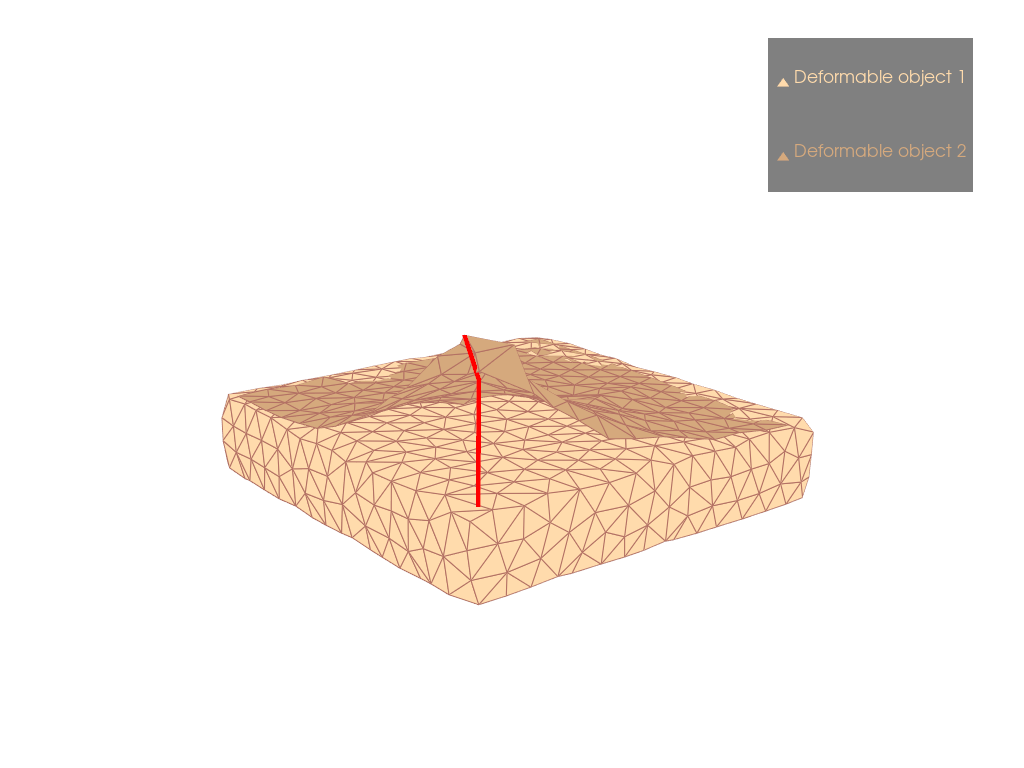

100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


tensor([ 0.0125, -0.0122,  0.0101], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


tensor([ 0.0130, -0.0127,  0.0106], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


tensor([ 0.0134, -0.0131,  0.0110], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


tensor([ 0.0139, -0.0136,  0.0115], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


tensor([ 0.0143, -0.0131,  0.0119], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


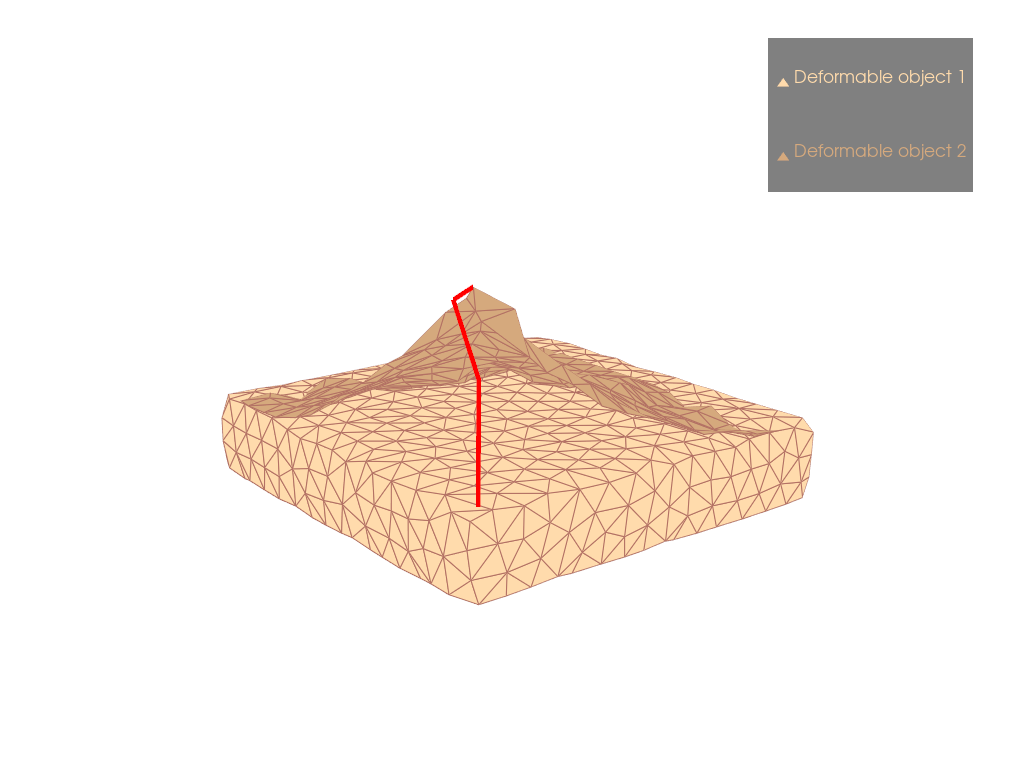

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


tensor([ 0.0148, -0.0136,  0.0124], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


tensor([ 0.0152, -0.0140,  0.0128], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


tensor([ 0.0157, -0.0145,  0.0124], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


tensor([ 0.0161, -0.0140,  0.0128], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


tensor([ 0.0166, -0.0136,  0.0124], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


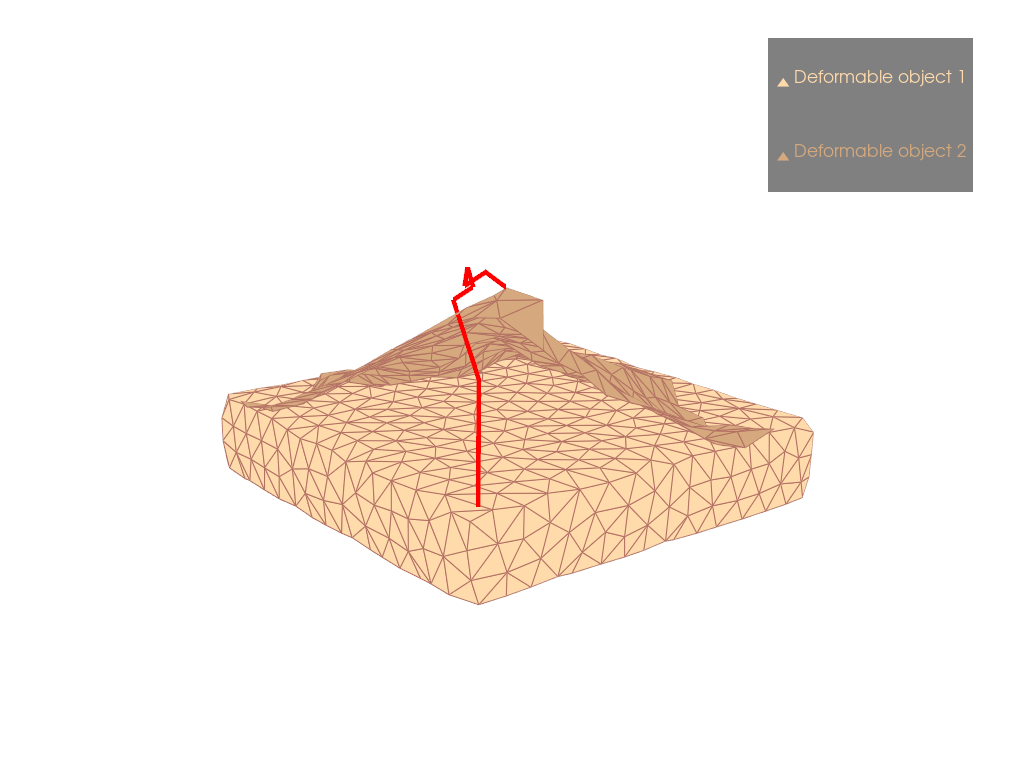

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


tensor([ 0.0161, -0.0131,  0.0119], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


tensor([ 0.0157, -0.0127,  0.0115], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


tensor([ 0.0152, -0.0122,  0.0110], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


tensor([ 0.0148, -0.0118,  0.0106], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


tensor([ 0.0143, -0.0113,  0.0101], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


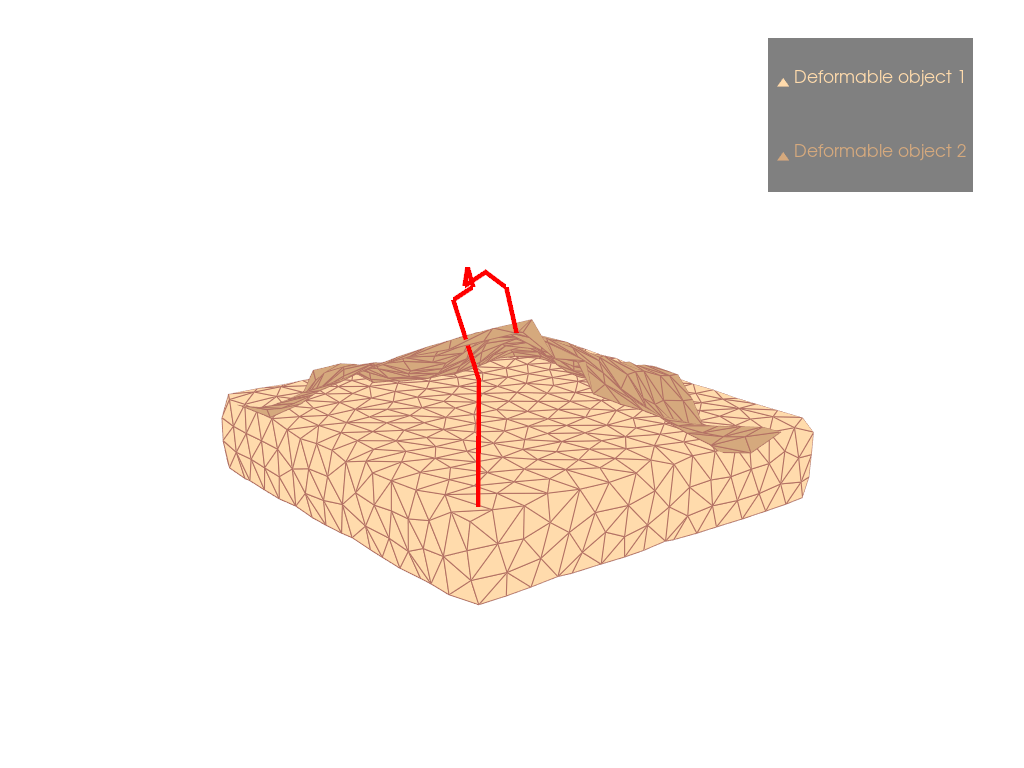

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


tensor([ 0.0139, -0.0109,  0.0097], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


tensor([ 0.0134, -0.0104,  0.0092], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


tensor([ 0.0139, -0.0100,  0.0088], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


tensor([ 0.0134, -0.0104,  0.0092], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


tensor([ 0.0130, -0.0100,  0.0097], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


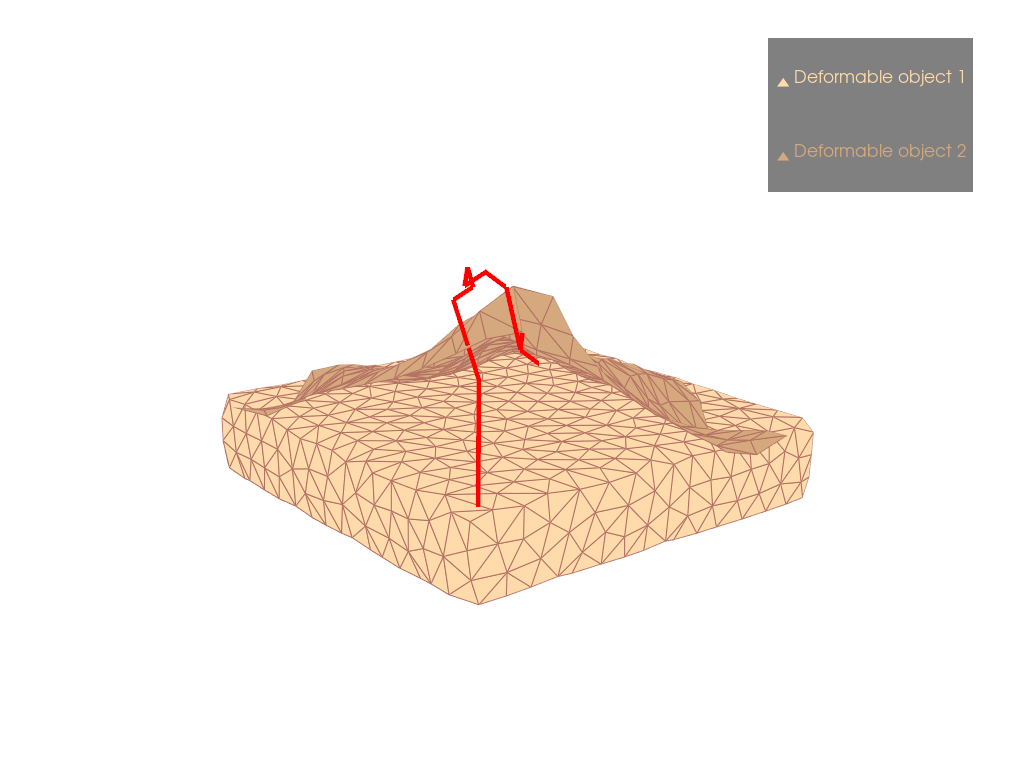

100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


tensor([ 0.0125, -0.0095,  0.0101], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


tensor([ 0.0121, -0.0100,  0.0106], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


tensor([ 0.0116, -0.0095,  0.0110], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


tensor([ 0.0112, -0.0091,  0.0106], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


tensor([ 0.0107, -0.0087,  0.0101], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


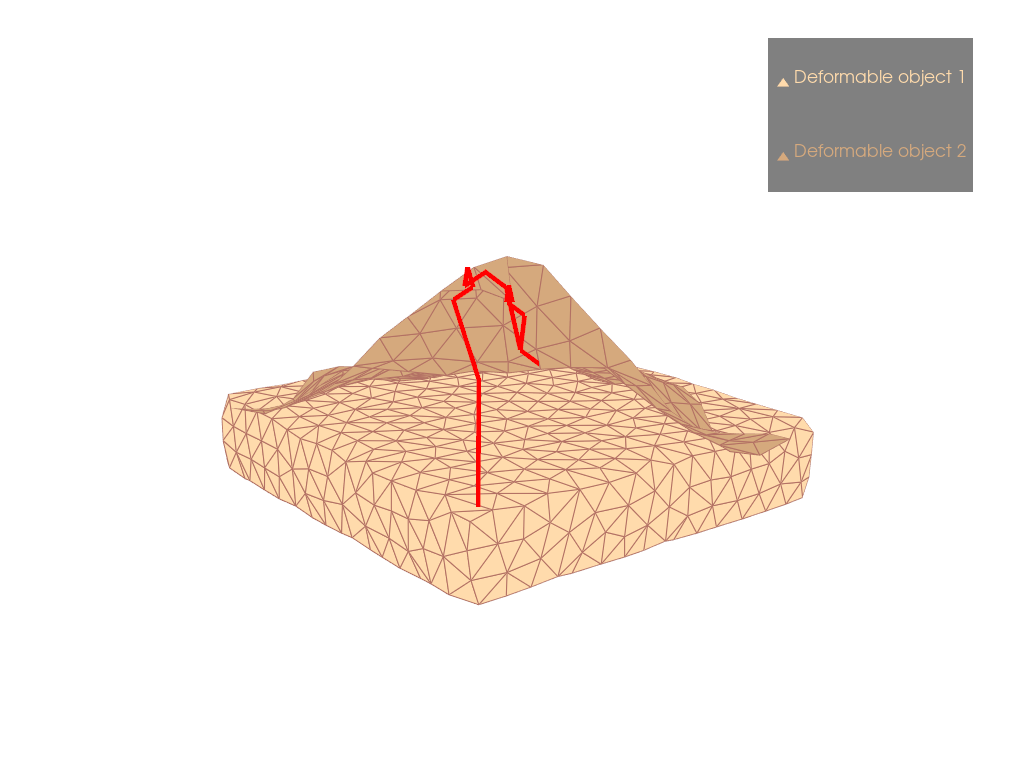

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


tensor([ 0.0103, -0.0082,  0.0097], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


tensor([ 0.0098, -0.0078,  0.0092], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


tensor([ 0.0094, -0.0073,  0.0088], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


tensor([ 0.0090, -0.0069,  0.0083], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


tensor([ 0.0085, -0.0064,  0.0079], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


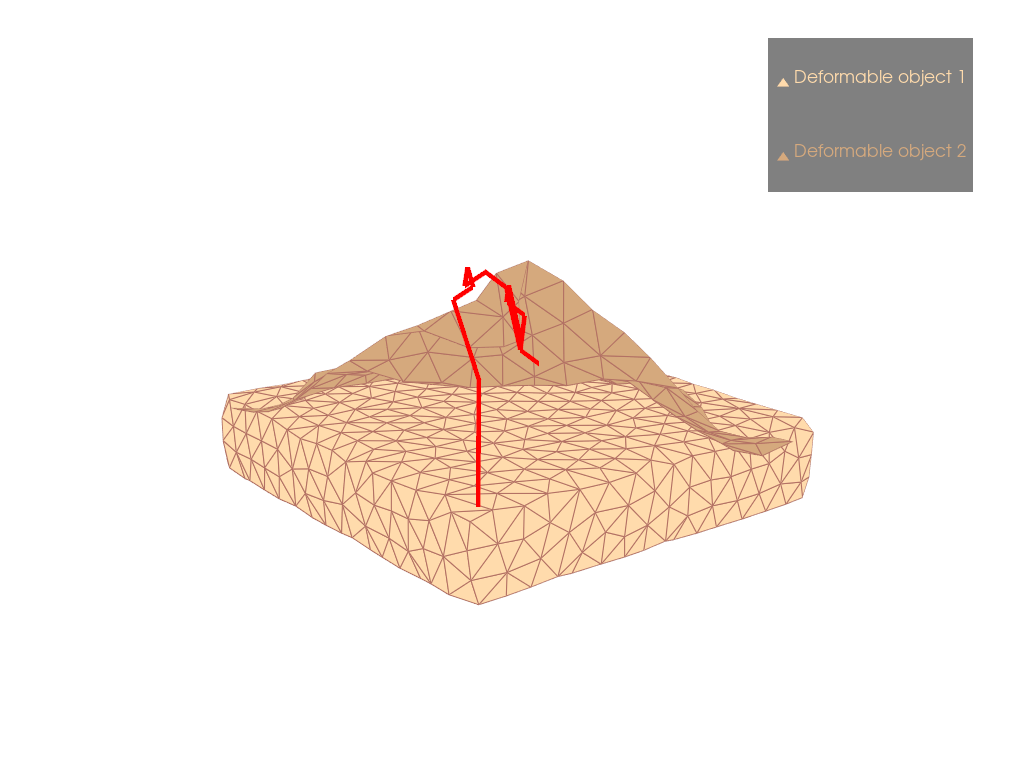

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


tensor([ 0.0081, -0.0060,  0.0074], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


tensor([ 0.0076, -0.0055,  0.0070], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


tensor([ 0.0072, -0.0051,  0.0066], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


tensor([ 0.0067, -0.0046,  0.0061], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]
/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


tensor([ 0.0063, -0.0042,  0.0057], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


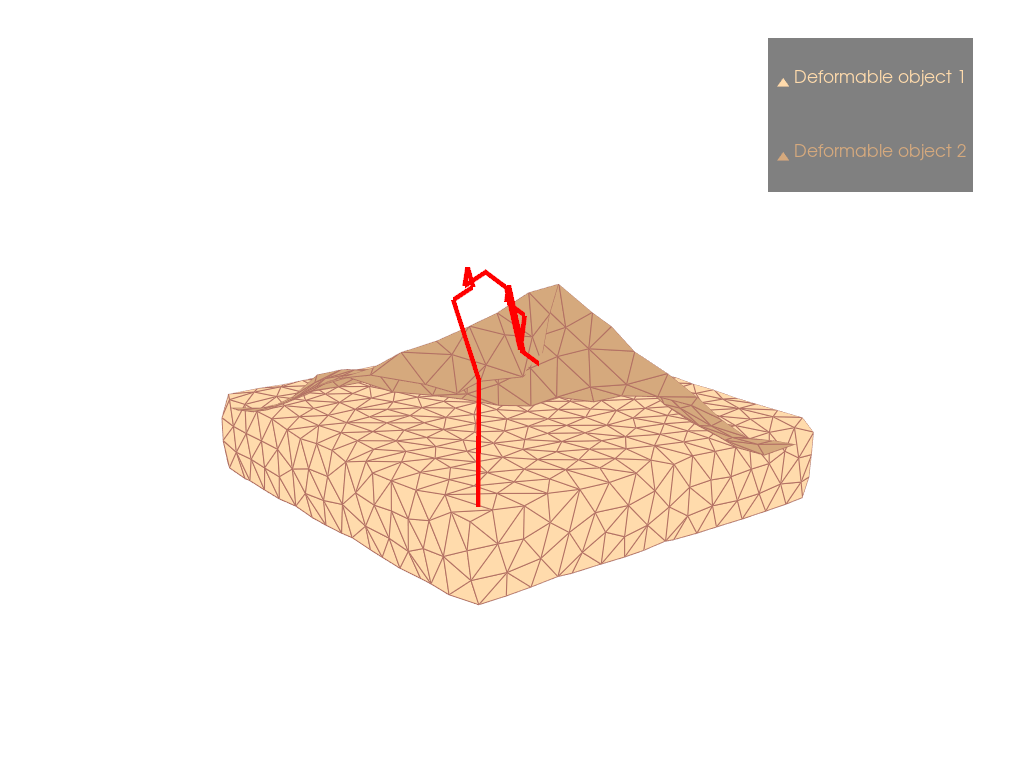

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


tensor([ 0.0058, -0.0046,  0.0052], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


tensor([ 0.0054, -0.0042,  0.0048], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


tensor([ 0.0049, -0.0046,  0.0043], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


tensor([ 0.0054, -0.0042,  0.0039], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


tensor([ 0.0049, -0.0046,  0.0034], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


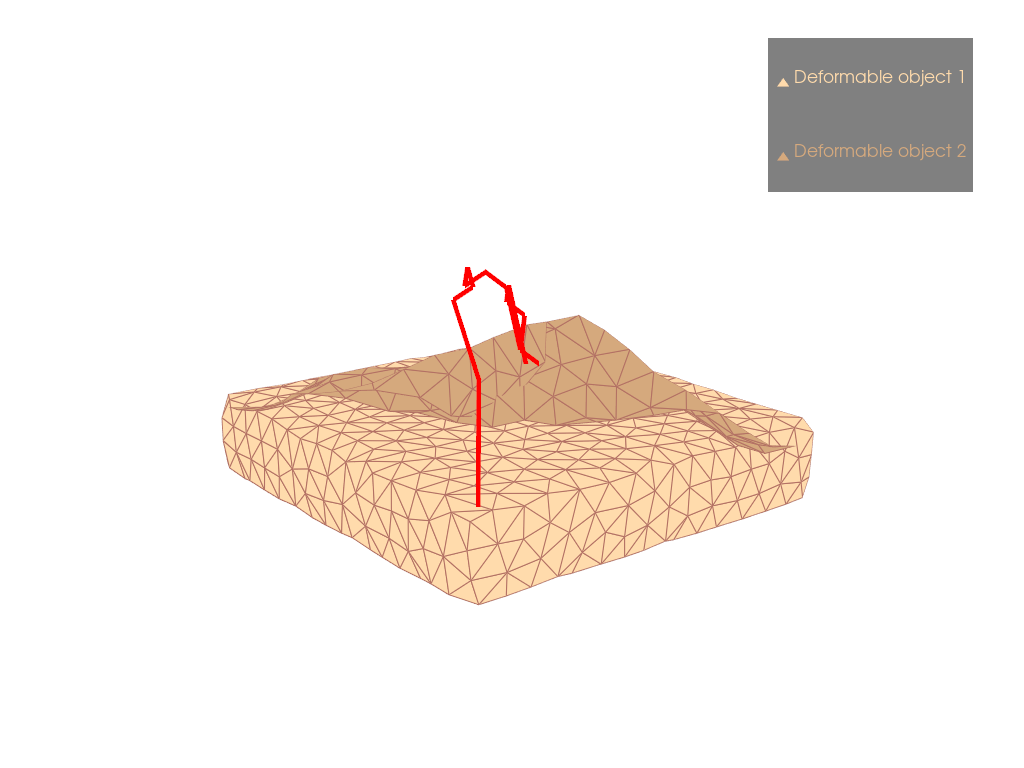

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


tensor([ 0.0045, -0.0042,  0.0030], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


tensor([ 0.0049, -0.0037,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


tensor([ 0.0045, -0.0042,  0.0021], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


tensor([ 0.0040, -0.0037,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


tensor([ 0.0036, -0.0033,  0.0021], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


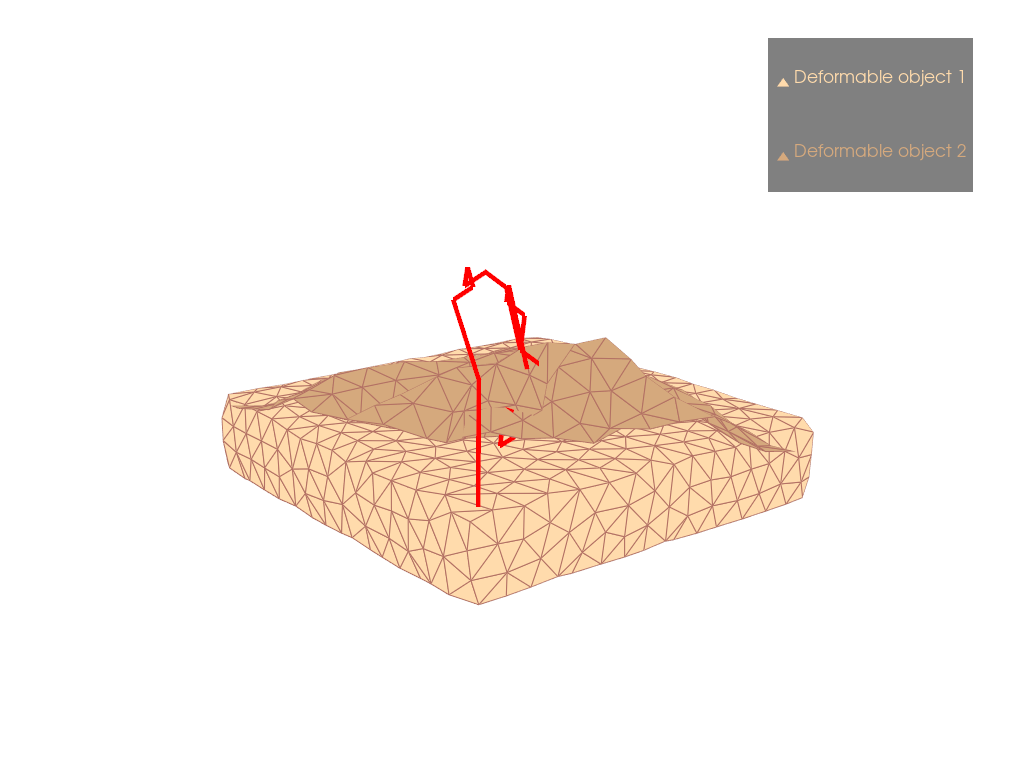

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


tensor([ 0.0031, -0.0028,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


tensor([ 0.0027, -0.0024,  0.0021], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


tensor([ 0.0022, -0.0028,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


tensor([ 0.0018, -0.0033,  0.0021], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


tensor([ 0.0022, -0.0037,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


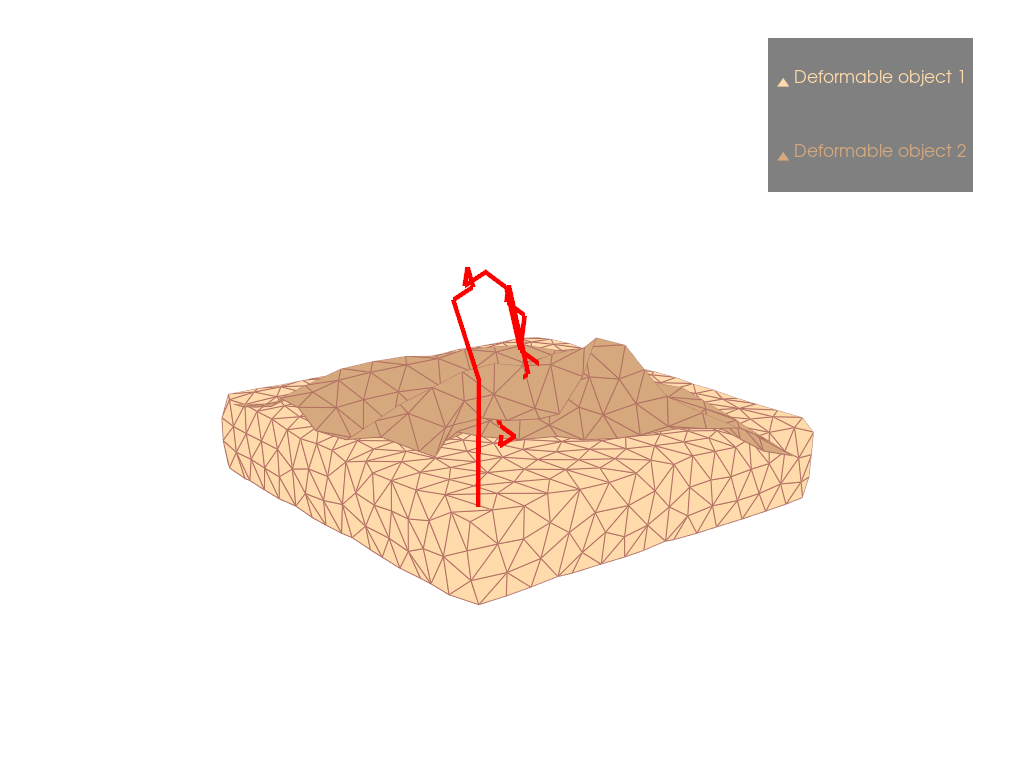

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


tensor([ 0.0018, -0.0042,  0.0021], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


tensor([ 0.0022, -0.0046,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


tensor([ 0.0018, -0.0042,  0.0021], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

tensor([ 0.0022, -0.0046,  0.0025], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


In [276]:
for n in range(60):
    # sampling
    spline_trajectory = spline_trajectory.detach().clone()
    # direct_vect = spline_trajectory[-1] - torch.mean(spline_trajectory, dim=0)
    start_point = spline_trajectory[-1]
    end_point = start_point
    # sample_x = torch.empty(sample_points).normal_(mean=float(end_point[0]),std=sigma)
    # sample_y = torch.empty(sample_points).normal_(mean=float(end_point[1]),std=sigma)
    # sample_z = torch.empty(sample_points).normal_(mean=float(end_point[2]),std=sigma)
    sample_x = torch.empty(sample_points).uniform_(end_point[0] - sigma, end_point[0] + sigma)
    sample_y = torch.empty(sample_points).uniform_(end_point[1] - sigma, end_point[1] + sigma)
    sample_z = torch.empty(sample_points).uniform_(end_point[2] - sigma, end_point[2] + sigma)

    end_points = torch.vstack((sample_x, sample_y, sample_z))
    end_points = torch.transpose(end_points, 0, 1)
    # print(end_points - start_point)
    spline_control = torch.zeros((sample_points, 3))
    energy_avg = torch.zeros(sample_points)
    TT_score = torch.zeros(sample_points)
    NN_score = torch.zeros(sample_points)
    constrain_score = torch.zeros(sample_points)

    start_point = start_point.reshape(1, 3)

    spline_sample_control = torch.zeros((B, MPC_step, 3))

    for i in range(sample_points):
        direction = end_points[i] - start_point
        direction = direction / (torch.norm(direction) / step_size)
        # print(direction)
        spline_ctrl = torch.zeros((5, 3))
        for j in range(5):
            spline_ctrl[j, :] = direction
        spline_sample_control[i] = spline_ctrl

    spline_sample_control = spline_sample_control.requires_grad_(True)
    optimizer = torch.optim.Adam([spline_sample_control], lr=0.001)
    
    for t in trange(opt_step):
        B = sample_points
        B_V_boundary_stiffness = V_boundary_stiffness.expand(B, *V_boundary_stiffness.shape)
        B_V_dist_stiffness = V_dist_stiffness.expand(B, *V_dist_stiffness.shape)
        B_V = softbody.V.expand(B, *softbody.V.shape).clone()
        B_V_velocity = softbody.V_velocity.expand(B, *softbody.V_velocity.shape)

        spline_sample_trajectory = torch.zeros((B, MPC_step, 3))
        spline_sample_trajectory[:, 0] = start_point
        for i in range(MPC_step - 1):
            spline_sample_trajectory[:, i + 1] = spline_sample_trajectory[:, i] + spline_sample_control[:, i] / (torch.norm(spline_sample_control, dim=1) / step_size)
        for i in range(MPC_step):
            B_V[:, softbody.offset_list[1] + control_point] = spline_sample_trajectory[:, i]
            step_parallel = XPBDStepBatch(softbody,
                                    V_dist_stiffness=B_V_dist_stiffness,
                                    V_boundary_stiffness=B_V_boundary_stiffness,
                                    dt=cfg.dt,
                                    substep=cfg.substep,
                                    iteration=cfg.iteration,
                                    plane_height=cfg.ground_plane_height, 
                                    quasi_static=cfg.quasi_static,
                                    use_boundary=True
                                    )
            B_V_pred, B_V_velocity_pred = step_parallel.forward_parallel(B_V, B_V_velocity)
            B_V = B_V_pred.clone()
            B_V_velocity = B_V_velocity_pred.clone()

            ref_B_V_boundary_stiffness = B_V_boundary_stiffness.clone()
            energy = get_energy_boundary_batch(softbody, B_V_pred, ref_B_V_boundary_stiffness)
            B_V_boundary_stiffness = B_V_boundary_stiffness * torch.sigmoid(B_energy_coff * (B_energy_threshold - energy)) + 1e-8 * torch.sigmoid(B_energy_coff * (energy - B_energy_threshold))
            energy_avg = torch.sum(energy, dim=1)
        # print(energy_avg)
        energy_avg = energy_avg / MPC_step
        loss = torch.zeros(B)
        for i in range(sample_points):
            loss[i] = loss_fn(B_V_boundary_stiffness[i], boundary_mask, 0, energy_avg[i])

        loss = torch.mean(loss)
        if t != opt_step - 1:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    energy_efficient = torch.zeros(sample_points)
    constrain_score = torch.zeros(sample_points)
    for i in range(sample_points):
        TT_score = eval(B_V_boundary_stiffness[i], boundary_mask)
        energy_efficient[i] = (TT_score - TT_score_prev) + 1 / energy_avg[i] / 1e9
        constrain_score[i] = (spline_sample_trajectory[i][1][-1] - 0.0020) < 0
        # print(i, TT_score - TT_score_prev, energy_avg[i], energy_efficient[i], constrain_score[i])
    
    # print(energy_efficient)
    sorted_score, sorted_idx = torch.sort(energy_efficient, descending=True)

    for i in sorted_idx:
        if constrain_score[i] == False:
            spline_trajectory = torch.vstack((spline_trajectory, spline_sample_trajectory[i][1]))
            break
    
    print(spline_trajectory[-1])
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[-1]
    # softbody.V[softbody.offset_list[1] + control_point][-1] += softbody.V[softbody.offset_list[1] + control_point][-1] + step_size
    # print(V_dist_stiffness)
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=False,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.detach().clone()
    softbody.V_velocity = V_velocity_ref.detach().clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))    
    V_boundary_stiffness = V_boundary_stiffness.detach().clone()
    
    TT_score_prev = eval(V_boundary_stiffness, boundary_mask)
    
    
    skin_mesh.points = softbody.V[:p_skin].detach().cpu().numpy()
    bandage_mesh.points = softbody.V[p_skin:].detach().cpu().numpy()
    if n % 5 == 0:
        pl = pv.Plotter()
        pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
        pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
        pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
        # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
        pl.add_legend()
        pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
                            (7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
                            (-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
        # pl.camera_position = 'xy'
        pl.show()

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


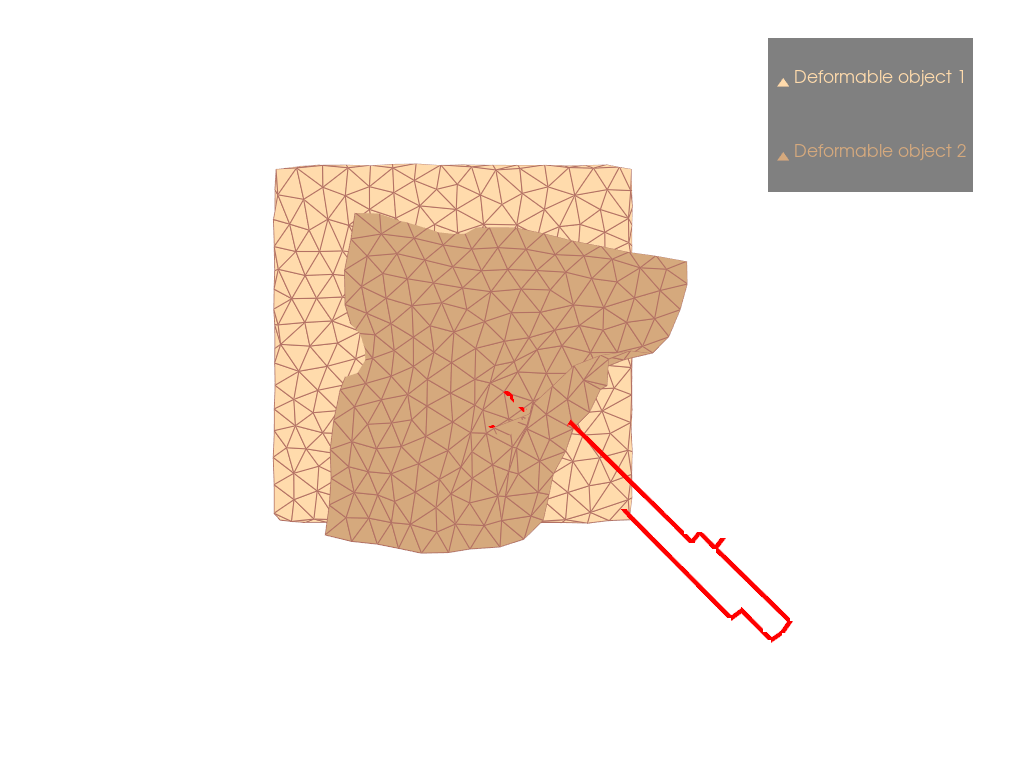

In [277]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
                        (7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
                        (-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
pl.camera_position = 'xy'
pl.show()

In [278]:
eval(V_boundary_stiffness, boundary_mask)

tensor(1.)